# Tutorial: Train and validate models
### 1. Load data and related packages
### 2. Train various models
#### 2.1 Train and tune LightGBM
#### 2.2 Visualize the results
#### 2.3 Save and load your Trainer
#### 2.4 Train other models
### 3. Cross validate models

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Load data and related packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

UCI Adult data are going to be used in this tutorial. The data contain both numerical and categorical features, and the target to predict is whether a person makes over 50K a year. It is a very simple binary classification task.

In [3]:
train = pd.read_csv('kuma_utils/datasets/adult_train.csv')
test = pd.read_csv('kuma_utils/datasets/adult_test.csv').iloc[1:]
test['Target'] = test['Target'].str[:-1]
test['Age'] = test['Age'].astype(int)

In [4]:
train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Let's prepare the data. We need to encode categorical features.

In [7]:
from xfeat import SelectCategorical, SelectNumerical, LabelEncoder
from kuma_utils.preprocessing.xfeat import Pipeline, TargetEncoder

In [8]:
num_enc = Pipeline([
    SelectNumerical(),
])

cat_enc = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix='')
], target_col='Target')

In [9]:
train_cat, train_num = cat_enc.fit_transform(train), num_enc.fit_transform(train)
categorical_index = list(range(train_cat.shape[1]))
train_encoded = pd.concat([train_cat, train_num], axis=1) 
train_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
0,0,0,0,0,0,0,0,0,0,39,77516,13,2174,0,40
1,1,0,1,1,1,0,0,0,0,50,83311,13,0,0,13
2,2,1,2,2,0,0,0,0,0,38,215646,9,0,0,40
3,2,2,1,2,1,1,0,0,0,53,234721,7,0,0,40
4,2,0,1,3,2,1,1,1,0,28,338409,13,0,0,40


Looks good to me. Let's apply the same transform to test data.

In [10]:
test_encoded = pd.concat([cat_enc.transform(test), num_enc.transform(test)], axis=1)
test_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
1,2,2,0,9,3,1,0,0,0,25,226802.0,7.0,0.0,0.0,40.0
2,2,1,1,8,1,0,0,0,0,38,89814.0,9.0,0.0,0.0,50.0
3,4,6,1,11,1,0,0,0,1,28,336951.0,12.0,0.0,0.0,40.0
4,2,5,1,9,1,1,0,0,1,44,160323.0,10.0,7688.0,0.0,40.0
5,-1,5,0,-1,3,0,1,0,0,18,103497.0,10.0,0.0,0.0,30.0


In [11]:
labels, features = train_encoded['Target'], train_encoded.drop('Target', axis=1)
labels_test, features_test = test_encoded['Target'], test_encoded.drop('Target', axis=1)

## 2. Train models
Before going to training, let's define our evaluation metric. Since the task is binary classification, I will use ROC-AUC for evaluation.

In [12]:
from sklearn.metrics import roc_auc_score, make_scorer
from kuma_utils.training import Trainer, auc_metric, acc_metric

### 2.1 Make Trainer

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

In [14]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params, fit_params=fit_params, 
)

Training until validation scores don't improve for 50 rounds
[25]	training's auc: 0.932287	valid_1's auc: 0.916136
[50]	training's auc: 0.944615	valid_1's auc: 0.92222
[75]	training's auc: 0.952074	valid_1's auc: 0.923407
[100]	training's auc: 0.957335	valid_1's auc: 0.923831
[125]	training's auc: 0.962092	valid_1's auc: 0.923186
[150]	training's auc: 0.965682	valid_1's auc: 0.923055
Early stopping, best iteration is:
[100]	training's auc: 0.957335	valid_1's auc: 0.923831


In [15]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 100
best_score: 0.9238309988445415

In [16]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9249370883560714

In [17]:
trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params, fit_params=fit_params, 
    tune_model=True, lgbm_n_trials=[5, 5, 5, 5, 5]
)

[I 2020-11-18 18:50:39,459] A new study created in memory with name: no-name-76aaa51d-13a4-4102-8c62-71e43156f6a1
min_data_in_leaf, val_score: 0.927197: 100%|##########| 5/5 [00:04<00:00,  1.17it/s]


In [18]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9273143382510531

In [19]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 158
best_score: 0.9271969056126466

### 2.2 Visualize the results

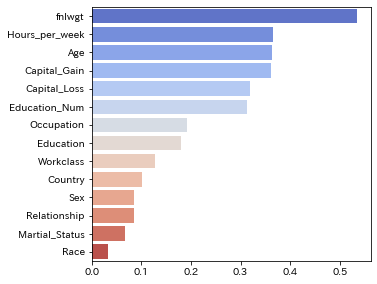

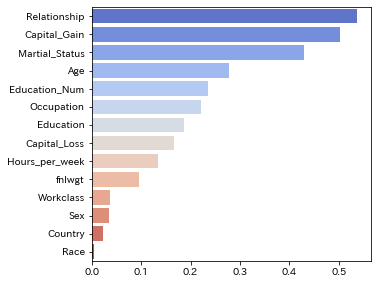

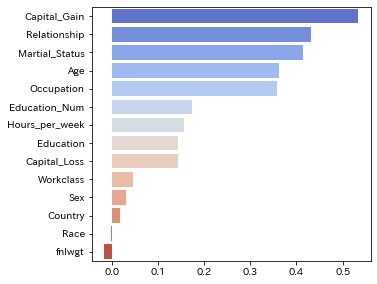

In [20]:
trn.plot_feature_importance()
trn.plot_feature_importance('gain')
trn.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

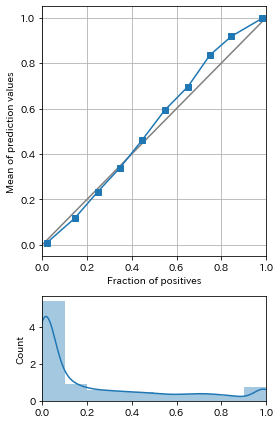

In [21]:
trn.plot_calibartion_curve(data=(x_train, y_train))

### 2.3 Save and load Trainer

In [22]:
trn.save('lgbm0.trainer')
trn = Trainer(path='lgbm0.trainer')
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 158
best_score: 0.9271969056126466

### 2.4 Train other models

In [23]:
params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 500,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 50,
    'verbose_eval': 25
}

trn2 = Trainer(CatBoostClassifier)
trn2.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params,
    # tune_model=True, maximize=True, n_trials=5,
    fit_params=fit_params)

Learning rate set to 0.095841
0:	test: 0.8814053	best: 0.8814053 (0)	total: 77.9ms	remaining: 38.9s
25:	test: 0.9118809	best: 0.9118809 (25)	total: 571ms	remaining: 10.4s
50:	test: 0.9188364	best: 0.9188364 (50)	total: 1.06s	remaining: 9.37s
75:	test: 0.9214195	best: 0.9214195 (75)	total: 1.54s	remaining: 8.62s
100:	test: 0.9223653	best: 0.9223960 (99)	total: 2.07s	remaining: 8.19s
125:	test: 0.9240584	best: 0.9240584 (125)	total: 2.6s	remaining: 7.72s
150:	test: 0.9255146	best: 0.9255146 (150)	total: 3.14s	remaining: 7.27s
175:	test: 0.9260102	best: 0.9260227 (174)	total: 3.73s	remaining: 6.87s
200:	test: 0.9263290	best: 0.9263489 (185)	total: 4.31s	remaining: 6.41s
225:	test: 0.9264901	best: 0.9265186 (221)	total: 4.87s	remaining: 5.9s
250:	test: 0.9264846	best: 0.9265198 (227)	total: 5.41s	remaining: 5.37s
275:	test: 0.9268114	best: 0.9268114 (275)	total: 5.98s	remaining: 4.85s
300:	test: 0.9268879	best: 0.9269698 (292)	total: 6.67s	remaining: 4.41s
325:	test: 0.9272838	best: 0.9272

In [24]:
roc_auc_score(labels_test, trn2.smart_predict(features_test)[:, 1])

0.9283210918304042

In [25]:
params = {}
fit_params = {}

trn3 = Trainer(LogisticRegression)
trn3.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    params=params,
    eval_metric=auc_metric, maximize=True,
    # tune_model=True, n_trials=5,
    fit_params=fit_params)

[-1]	best score is 0.584467


In [26]:
roc_auc_score(labels_test, trn3.predict_proba(features_test)[:, 1])

0.5707927400328825

## 3. Cross validate models

In [27]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
)

[25]	cv_agg's auc: 0.919932 + 0.00349363
[50]	cv_agg's auc: 0.9252 + 0.00314706
[75]	cv_agg's auc: 0.925487 + 0.00289121
[100]	cv_agg's auc: 0.925613 + 0.00290994
[125]	cv_agg's auc: 0.925751 + 0.00310033
[150]	cv_agg's auc: 0.925324 + 0.00304159
[175]	cv_agg's auc: 0.925018 + 0.00301846
[125]	best score is 0.925751


In [28]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 125
best_score: 0.9257509869339163

In [29]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0)[:, 1])

0.9264433713657352

**Note that Trainer.cv() is cross validation during training process.** The model is fit to the whole data rather than each fold. This returns models with same hyperparameters, but trained on different data.

In [30]:
from kuma_utils.training import CrossValidator

In [31]:
validator = CrossValidator(LGBMClassifier)
validator.train(
    data=(features, labels), params=params, fit_params=fit_params,
    folds=StratifiedKFold(n_splits=5)
)

[cv0] Starting fold 0
[cv0] Fold 0: eval=0.926061 (iter=127)
[cv0] Starting fold 1
[cv0] Fold 1: eval=0.925534 (iter=134)
[cv0] Starting fold 2
[cv0] Fold 2: eval=0.929985 (iter=89)
[cv0] Starting fold 3
[cv0] Fold 3: eval=0.929366 (iter=151)
[cv0] Starting fold 4
[cv0] Fold 4: eval=0.929537 (iter=122)
[cv0] Overall metric: 0.928097 + 0.001896


In [32]:
validator

CrossValidator: cv0
models: [Trainer: cv0_fold0
model: LGBMClassifier()
is_trained: True
best_iteration: 127
best_score: 0.9260606620794066
, Trainer: cv0_fold1
model: LGBMClassifier()
is_trained: True
best_iteration: 134
best_score: 0.9255337716093719
, Trainer: cv0_fold2
model: LGBMClassifier()
is_trained: True
best_iteration: 89
best_score: 0.9299845772653722
, Trainer: cv0_fold3
model: LGBMClassifier()
is_trained: True
best_iteration: 151
best_score: 0.9293663005250644
, Trainer: cv0_fold4
model: LGBMClassifier()
is_trained: True
best_iteration: 122
best_score: 0.929537284422264
]
is_trained: True
best_score: [0.9280965191802958, 0.00189553695432855]

In [33]:
roc_auc_score(labels_test, np.stack(validator.smart_predict(features_test)).mean(0)[:, 1])

0.9272003915942726

Now this one is an intuitive cross validation, in which models are fit to each fold.